## 1.Autoencoder

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
import keras
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from keras.preprocessing.image import img_to_array, array_to_img
from keras.engine import Model
from keras import optimizers
import sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, auc
tfkl = tfk.layers

In [ ]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
(trainX.shape, trainy.shape)

((50000, 32, 32, 3), (50000, 1))

In [ ]:
(testX.shape, testy.shape)

((10000, 32, 32, 3), (10000, 1))

In [ ]:
# normalize between 0-1
x_train = trainX.astype('float32')/255.0
x_test = testX.astype('float32')/255.0

In [ ]:
# Define the Model
input_img = keras.Input(shape=(32, 32, 3))

x = tfkl.Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
x = tfkl.MaxPooling2D((2, 2), padding='same')(x)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = tfkl.MaxPooling2D((2, 2), padding='same')(x)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = tfkl.BatchNormalization(axis=-1)(x)
encoded = tfkl.MaxPooling2D((2, 2), padding='same')(x)


x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(encoded)
x = tfkl.UpSampling2D((2, 2))(x)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = tfkl.UpSampling2D((2, 2))(x)
x = tfkl.BatchNormalization(axis=-1)(x)
x = tfkl.Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = tfkl.UpSampling2D((2, 2))(x)
x = tfkl.BatchNormalization(axis=-1)(x)
decoded = tfkl.Conv2D(3, (3, 3), activation='sigmoid', padding='same', use_bias=False)(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        864       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 16)        4608      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 16)         

In [ ]:
cbs = [tfk.callbacks.EarlyStopping(min_delta=0, patience=7)]

results = autoencoder.fit(x_train, 
                          x_train,
                          epochs=20,
                          batch_size=64,
                          shuffle = True,
                          validation_data=(x_test, x_test),
                          callbacks=cbs)

Epoch 1/20
782/782 [==============================] - 197s 252ms/step - loss: 0.5873 - val_loss: 0.5856
Epoch 2/20
782/782 [==============================] - 202s 258ms/step - loss: 0.5768 - val_loss: 0.5769
Epoch 3/20
782/782 [==============================] - 198s 253ms/step - loss: 0.5739 - val_loss: 0.5749
Epoch 4/20
782/782 [==============================] - 197s 252ms/step - loss: 0.5721 - val_loss: 0.5723
Epoch 5/20
782/782 [==============================] - 198s 253ms/step - loss: 0.5710 - val_loss: 0.5719
Epoch 6/20
782/782 [==============================] - 197s 251ms/step - loss: 0.5702 - val_loss: 0.5750
Epoch 7/20
782/782 [==============================] - 197s 252ms/step - loss: 0.5695 - val_loss: 0.5690
Epoch 8/20
782/782 [==============================] - 198s 253ms/step - loss: 0.5690 - val_loss: 0.5694
Epoch 9/20
782/782 [==============================] - 197s 253ms/step - loss: 0.5687 - val_loss: 0.5700
Epoch 10/20
782/782 [==============================] - 199s 254m

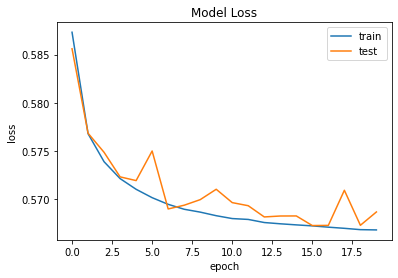

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(labels=['train', 'test'])
plt.title('Model Loss')
plt.show()

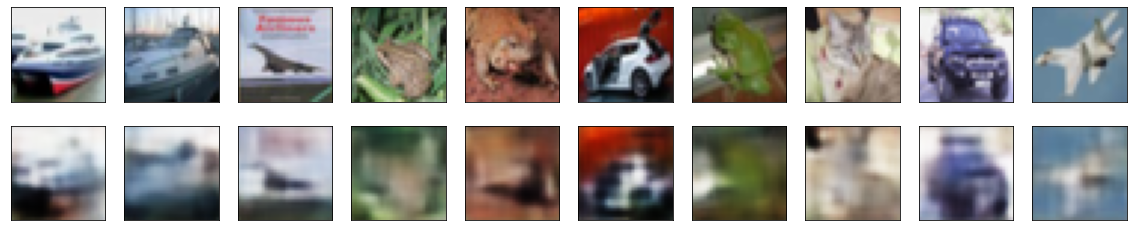

In [ ]:
# Visualize examples before and after autoencoder
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##  2.1 Deep CNN

In [ ]:
model = tfk.Sequential()
model.add(tfkl.Conv2D(64, kernel_size=(3,3), strides=1, padding='valid', activation='relu', input_shape=(32,32,3)))
model.add(tfkl.MaxPool2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.3))
model.add(tfkl.Conv2D(32, kernel_size=(3,3), strides=1, padding='valid', activation='relu', input_shape=(32,32,3)))
model.add(tfkl.MaxPool2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.3))
model.add(tfkl.Flatten())
model.add(tfkl.Dense(256, activation='relu'))
model.add(tfkl.Dropout(0.5))
model.add(tfkl.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

In [ ]:
y_train = tf.keras.utils.to_categorical(trainy)
y_test = tf.keras.utils.to_categorical(testy)

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

results2= model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x_test, y_test))

Epoch 1/20
782/782 [==============================] - 87s 111ms/step - loss: 1.4999 - accuracy: 0.4562 - val_loss: 1.2747 - val_accuracy: 0.5515
Epoch 2/20
782/782 [==============================] - 86s 110ms/step - loss: 1.3147 - accuracy: 0.5321 - val_loss: 1.1543 - val_accuracy: 0.6004
Epoch 3/20
782/782 [==============================] - 86s 110ms/step - loss: 1.2196 - accuracy: 0.5661 - val_loss: 1.0806 - val_accuracy: 0.6304
Epoch 4/20
782/782 [==============================] - 86s 110ms/step - loss: 1.1629 - accuracy: 0.5890 - val_loss: 1.0118 - val_accuracy: 0.6477
Epoch 5/20
782/782 [==============================] - 86s 110ms/step - loss: 1.1156 - accuracy: 0.6070 - val_loss: 0.9928 - val_accuracy: 0.6543
Epoch 6/20
782/782 [==============================] - 86s 109ms/step - loss: 1.0786 - accuracy: 0.6194 - val_loss: 0.9541 - val_accuracy: 0.6659
Epoch 7/20
782/782 [==============================] - 86s 110ms/step - loss: 1.0445 - accuracy: 0.6335 - val_loss: 0.9535 - val_ac

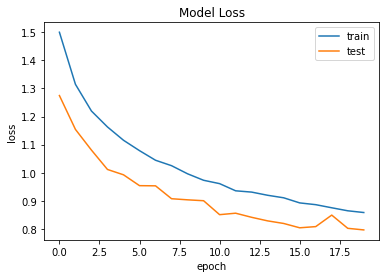

In [ ]:
plt.plot(results2.history['loss'])
plt.plot(results2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(labels=['train', 'test'])
plt.title('Model Loss')
plt.show()

## 2.2 Transfer Learning

In [ ]:
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
base = VGG16(weights = 'imagenet', include_top = False, input_shape = (48,48,3))
base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [ ]:
model = tfk.Sequential()
model.add(conv_base)
model.add(tfkl.Flatten())
model.add(tfkl.Dense(64, activation='relu'))
model.add(tfkl.Dropout(0.5))
model.add(tfkl.Dense(10, activation='softmax'))

In [ ]:
for layer in base.layers:
     layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [ ]:
results3 = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=5,
                    validation_data=(x_test, y_test))

Epoch 1/5
1563/1563 [==============================] - 880s 563ms/step - loss: 0.3192 - accuracy: 0.1479 - val_loss: 0.3164 - val_accuracy: 0.1635
Epoch 2/5
1563/1563 [==============================] - 878s 562ms/step - loss: 0.3166 - accuracy: 0.1578 - val_loss: 0.3151 - val_accuracy: 0.1667
Epoch 3/5
1563/1563 [==============================] - 878s 562ms/step - loss: 0.3153 - accuracy: 0.1649 - val_loss: 0.3145 - val_accuracy: 0.1664
Epoch 4/5
1563/1563 [==============================] - 880s 563ms/step - loss: 0.3144 - accuracy: 0.1687 - val_loss: 0.3145 - val_accuracy: 0.1609
Epoch 5/5
1563/1563 [==============================] - 882s 564ms/step - loss: 0.3134 - accuracy: 0.1727 - val_loss: 0.3135 - val_accuracy: 0.1696


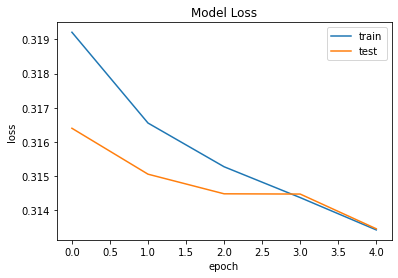

In [ ]:
plt.plot(results3.history['loss'])
plt.plot(results3.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(labels=['train', 'test'])
plt.title('Model Loss')
plt.show()

## 3.1 RNN

In [47]:
df = pd.read_csv("SPAM_detection.csv")
df.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [48]:
x = df['Message']
y = df['category_val']

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
x = tokenizer.texts_to_sequences(x)
x = sequence.pad_sequences(x)

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [51]:
x_train = pad_sequences(x_train, padding='post', maxlen=64)
x_test = pad_sequences(x_test, padding='post', maxlen=64)

In [52]:
model_rnn = tfk.Sequential([
  tfkl.Embedding(len(tokenizer.word_index)+1,10,input_length=x_train.shape[1]),
  tfkl.LSTM(64,return_sequences=True),
  tfkl.GlobalMaxPool1D(),
  tfkl.Dropout(0.3),
  tfkl.Dense(1,activation='sigmoid')                                
])

model_rnn.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 64, 10)            90050     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64, 64)            19200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 109,315
Trainable params: 109,315
Non-trainable params: 0
_________________________________________________________________


In [53]:
model_rnn.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.RMSprop(lr=0.01),metrics=['accuracy'])
results_rnn = model_rnn.fit(x_train, 
                            y_train, 
                            epochs=20, 
                            batch_size=64, 
                            shuffle=True,
                            validation_data=(x_test, y_test))

Epoch 1/20
61/61 [==============================] - 4s 58ms/step - loss: 0.2870 - accuracy: 0.8944 - val_loss: 0.0574 - val_accuracy: 0.9874
Epoch 2/20
61/61 [==============================] - 3s 51ms/step - loss: 0.0516 - accuracy: 0.9879 - val_loss: 0.0423 - val_accuracy: 0.9892
Epoch 3/20
61/61 [==============================] - 3s 51ms/step - loss: 0.0301 - accuracy: 0.9921 - val_loss: 0.0372 - val_accuracy: 0.9892
Epoch 4/20
61/61 [==============================] - 3s 52ms/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.0485 - val_accuracy: 0.9874
Epoch 5/20
61/61 [==============================] - 3s 53ms/step - loss: 0.0143 - accuracy: 0.9959 - val_loss: 0.0584 - val_accuracy: 0.9856
Epoch 6/20
61/61 [==============================] - 3s 52ms/step - loss: 0.0071 - accuracy: 0.9985 - val_loss: 0.0579 - val_accuracy: 0.9868
Epoch 7/20
61/61 [==============================] - 3s 53ms/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.0757 - val_accuracy: 0.9856
Epoch 8/20
61

## 3.2 CNN

In [54]:
model_cnn = tfk.Sequential([
  tfkl.Conv1D(filters= 64,kernel_size=2,strides=1,activation='relu',padding='same',input_shape=(x_train.shape[1],1)),
  tfkl.MaxPooling1D(pool_size=2,padding='same'),
  tfkl.Conv1D(filters = 64, kernel_size=2,strides=1,activation='relu',padding='same'),
  tfkl.Dropout(0.3),
  tfkl.Conv1D(32,kernel_size=2,strides=1,activation='relu',padding='same'),   
  tfkl.Flatten(),
  tfkl.Dense(16,activation='relu'),
  tfkl.Dense(1,activation='sigmoid')                     
])
model_cnn.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 64, 64)            192       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 32, 64)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 32, 64)            8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 32, 32)            4128      
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)              

In [55]:
x_train_ = x_train[:,:,None]
x_test = x_test[:,:,None]

In [57]:
model_cnn.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.Adam(),metrics=['accuracy'])

In [60]:
results_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=20, 
                            batch_size=64, 
                            validation_data=(x_test, y_test))

Epoch 1/20


ValueError: ignored

## 3.3 Model Comparison

In [59]:
y_pred_rnn = model_rnn.predict(x_test)
fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(y_test, y_pred_rnn)
auc_rnn = auc(fpr_rnn, tpr_rnn)

In [ ]:
y_pred_cnn = model_cnn.predict(x_test_)
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)

In [ ]:
plt.figure()
plt.plot([0, 1], [0, 1], 'm--')
plt.plot(fpr_rnn, tpr_rnn, label='RNN (area = {:.3f})'.format(auc_rnn))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc = 'lower right')
plt.show()